In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function

import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, models
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from skimage.io import imsave
import cv2
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
x_test_path = '/content/drive/My Drive/Colab Notebooks/Test/original_retinal_images/'
y_test_path = '/content/drive/My Drive/Colab Notebooks/Test/blood_vessel_segmentation_masks/'

In [0]:
def read_data(path):
    image_names = sorted(os.listdir(path))
    #print(image_names)
    l = []
    for i in range(len(image_names)):
        tmp = cv2.imread(path + image_names[i], 0)
        l.append(tmp)

    return np.asanyarray(l)

In [5]:
x_test = read_data(x_test_path) / 255
y_test = read_data(y_test_path) / 255

x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=3)

x_test.shape, y_test.shape

((20, 512, 512, 1), (20, 512, 512, 1))

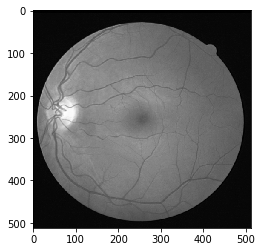

In [6]:
plt.imshow(x_test[1].reshape((512,512)), cmap = 'gray')

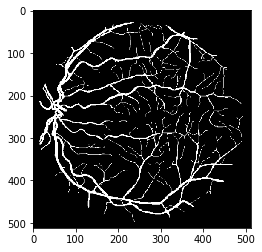

In [7]:
plt.imshow(y_test[1].reshape((512,512)), cmap = 'gray')

In [8]:
x_test[1].max(), y_test[1].max()

(1.0, 1.0)

In [0]:
smooth = 1.
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [0]:
def get_segnet(input_size = (512,512,1)):
    kernel = 3

    encoding_layers = [
        Conv2D(32, (kernel, kernel), padding='same', input_shape=input_size),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(32, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        MaxPooling2D(),
    ]

    autoencoder = models.Sequential()
    autoencoder.encoding_layers = encoding_layers

    for l in autoencoder.encoding_layers:
        autoencoder.add(l)

    decoding_layers = [
        UpSampling2D(size=(2, 2)),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),
        Conv2D(32, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        UpSampling2D(size=(2, 2)),
        Conv2D(32, (kernel, kernel), padding='same'),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(1, (1, 1), padding='valid'),
        BatchNormalization(axis=3),
    ]
    autoencoder.decoding_layers = decoding_layers
    for l in autoencoder.decoding_layers:
        autoencoder.add(l)

    autoencoder.add(Activation('sigmoid'))
    autoencoder.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3),
                        metrics=[dice_coef, 'accuracy', precision, recall, f1score])
    autoencoder.summary()

    return autoencoder

In [12]:
model = get_segnet()
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 512, 512, 32)      0         
___________

In [0]:
def gene():

    data_gen_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        rescale=1./255,
                        fill_mode='nearest')

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1
    #image_datagen.fit(images, augment=True, seed=seed)
    #mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Training/',classes = ['original_retinal_images'],
        class_mode=None, color_mode = "grayscale", target_size = (512,512), batch_size = 5,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        '/content/drive/My Drive/Colab Notebooks/Training/',classes = ['blood_vessel_segmentation_masks'],
        class_mode=None, color_mode = "grayscale", target_size = (512,512), batch_size = 5,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)

    '''
    n = 1
    
    for i,j in train_generator:
        #print("n = ", n)
        n += 1
        f = plt.figure(figsize=(4, 4))
        f.add_subplot(121)
        plt.imshow(i[0].reshape((512,512)), cmap = 'gray')
        plt.axis('off')
        f.add_subplot(122)
        plt.imshow(j[0].reshape((512,512)), cmap = 'gray')
        plt.axis('off')

        plt.show(block=True)
        print(i[0].max(),j[0].max())
    '''

    return train_generator

In [14]:
myGene = gene()

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(patience=5, verbose=1)

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5')

In [0]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=30,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/30
1000/1000 [==============================] - 952s 952ms/step - loss: 0.5789 - dice_coef: 0.2258 - acc: 0.8066 - precision: 0.3492 - recall: 0.6253 - f1score: 0.4454 - val_loss: -18.7235 - val_dice_coef: 1.1785 - val_acc: 0.4046 - val_precision: 0.2001 - val_recall: 0.8922 - val_f1score: 0.3268

Epoch 00001: loss improved from inf to 0.57887, saving model to /content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5
Epoch 2/30
1000/1000 [==============================] - 951s 951ms/step - loss: 0.5100 - dice_coef: 0.2584 - acc: 0.8494 - precision: 0.5036 - recall: 0.7078 - f1score: 0.5880 - val_loss: 54.3144 - val_dice_coef: 0.3409 - val_acc: 0.7816 - val_precision: 1.0745 - val_recall: 0.9186 - val_f1score: 0.9897

Epoch 00002: loss improved from 0.57887 to 0.51002, saving model to /content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5
Epoch 3/30
1000/1000 [==============================] - 951s 951ms/step - loss: 0.4622 - dice_coef: 0.2787 - acc: 0.8591 - precision: 0.5

In [0]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=30,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/30
1000/1000 [==============================] - 967s 967ms/step - loss: 0.1305 - dice_coef: 0.5540 - acc: 0.8648 - precision: 0.6845 - recall: 0.5630 - f1score: 0.6129 - val_loss: 0.1652 - val_dice_coef: 0.5885 - val_acc: 0.9022 - val_precision: 0.6173 - val_recall: 0.6392 - val_f1score: 0.6277

Epoch 00001: loss did not improve from 0.08378
Epoch 2/30
1000/1000 [==============================] - 955s 955ms/step - loss: 0.0916 - dice_coef: 0.6676 - acc: 0.8695 - precision: 0.7314 - recall: 0.6699 - f1score: 0.6986 - val_loss: 0.1607 - val_dice_coef: 0.5912 - val_acc: 0.9051 - val_precision: 0.6615 - val_recall: 0.5840 - val_f1score: 0.6200

Epoch 00002: loss did not improve from 0.08378
Epoch 3/30
1000/1000 [==============================] - 959s 959ms/step - loss: 0.0812 - dice_coef: 0.7017 - acc: 0.8702 - precision: 0.7412 - recall: 0.6951 - f1score: 0.7169 - val_loss: 0.1695 - val_dice_coef: 0.6148 - val_acc: 0.9060 - val_precision: 0.6676 - val_recall: 0.6068 - val_f1score:

In [18]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=15,callbacks=[model_checkpoint], validation_data = (x_test, y_test))

Epoch 1/15
1000/1000 [==============================] - 286s 286ms/step - loss: 0.0620 - dice_coef: 0.7703 - acc: 0.8709 - precision: 0.7615 - recall: 0.7535 - f1score: 0.7574 - val_loss: 0.2093 - val_dice_coef: 0.6240 - val_acc: 0.9066 - val_precision: 0.6890 - val_recall: 0.5729 - val_f1score: 0.6251

Epoch 00001: loss did not improve from 0.06176
Epoch 2/15
1000/1000 [==============================] - 279s 279ms/step - loss: 0.0617 - dice_coef: 0.7716 - acc: 0.8709 - precision: 0.7619 - recall: 0.7549 - f1score: 0.7583 - val_loss: 0.2094 - val_dice_coef: 0.6282 - val_acc: 0.9063 - val_precision: 0.6823 - val_recall: 0.5819 - val_f1score: 0.6277

Epoch 00002: loss improved from 0.06176 to 0.06166, saving model to /content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5
Epoch 3/15
1000/1000 [==============================] - 276s 276ms/step - loss: 0.0612 - dice_coef: 0.7732 - acc: 0.8709 - precision: 0.7627 - recall: 0.7567 - f1score: 0.7596 - val_loss: 0.2136 - val_dice_coef: 0.63

KeyboardInterrupt: ignored

In [23]:
history = model.fit_generator(myGene,
                    steps_per_epoch=1000,
                    epochs=15,callbacks=[model_checkpoint, early_stopping], validation_data = (x_test, y_test))

Epoch 1/15
1000/1000 [==============================] - 280s 280ms/step - loss: 0.0606 - dice_coef: 0.7752 - acc: 0.8710 - precision: 0.7636 - recall: 0.7587 - f1score: 0.7611 - val_loss: 0.2180 - val_dice_coef: 0.6281 - val_acc: 0.9068 - val_precision: 0.6939 - val_recall: 0.5714 - val_f1score: 0.6263

Epoch 00001: loss improved from inf to 0.06061, saving model to /content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5
Epoch 2/15
1000/1000 [==============================] - 274s 274ms/step - loss: 0.0606 - dice_coef: 0.7754 - acc: 0.8710 - precision: 0.7635 - recall: 0.7588 - f1score: 0.7610 - val_loss: 0.2160 - val_dice_coef: 0.6289 - val_acc: 0.9067 - val_precision: 0.6890 - val_recall: 0.5779 - val_f1score: 0.6281

Epoch 00002: loss improved from 0.06061 to 0.06061, saving model to /content/drive/My Drive/Colab Notebooks/segnet_task_2.hdf5
Epoch 3/15
 589/1000 [================>.............] - ETA: 1:53 - loss: 0.0608 - dice_coef: 0.7750 - acc: 0.8708 - precision: 0.7635 - rec

KeyboardInterrupt: ignored